## This is the same base code as `testing2` and `NAO_FCNN` but this is a regular ANN attempt for multi-dimensional input and output. 

#### These next three chunks are just a bunch of import statements.

In [1]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

/tmp/ipykernel_693079/3801934532.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

2024-11-11 20:08:55.053789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 20:08:55.053866: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 20:08:55.053922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 20:08:55.061630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.compat.v1.disable_eager_execution()
import investigate

#### Upload data. 

In [4]:
#inputs
infile = open("./data/ANN/sing_gph500_dailyanoms.p", 'rb') 
input = pickle.load(infile)
infile.close()

#outputs
infile = open("./data/ANN/sing_EURtemp_anoms.p", 'rb')
temp = pickle.load(infile)
infile.close()
#temp = temp.flatten()

In [5]:
##input shape (samples, lat, lon), these will be different from the output
input.shape

(8442, 31, 361)

In [6]:
##output shape (samples, lat, lon), these will be different from the input
temp.shape

(8442,)

In [7]:
##Set X_all and Y_all datasets
X_all = np.copy(input)
Y_all = np.copy(temp)

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)

In [8]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [9]:
##set fraction of data as 15% 
frac = round(len(X_all[:,0])*0.15)
frac

1266

In [10]:
##checking to make sure shape was properly one hot encoded
Y_all.shape

(8442, 2)

In [11]:
######
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 60 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [12]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [13]:
#number_inputs = X_all.shape[-1] ##number of samples ... I might need this later but it is commented out for now
X_validation = X_all[0:int(frac)]
Y_validation = Y_all[0:int(frac)]
        
X_train = X_all[int(frac):len(X_all)-int(frac)]
Y_train = Y_all[int(frac):len(Y_all)-int(frac)]

X_test = X_all[len(X_all)-int(frac):]
Y_test = Y_all[len(Y_all)-int(frac):]


##need to specify the shapes of the lat and lon because they are different for input and output
in_lat = len(input[0,:,0])

in_lon = len(input[0,0,:]) 

In [14]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.1129782}

In [15]:
X_validation.shape

(1266, 31, 361)

### Model Arcitecture.

In [41]:
##as stated before, this is going to be really simple.
#I am not specifying the number of nodes or regularizers or anything like that. 

def create_model(in_lat, in_lon, num_categories):
    # Define the functional API model
    inputs = layers.Input(shape=(in_lat, in_lon))

    # Flatten the input data (since it's 2D, we need to flatten it into a 1D vector)
    x = layers.Flatten()(inputs)

    # First fully connected layer (Dense layer)
    x = layers.Dense(1000, activation='relu',kernel_initializer='he_normal',
                      bias_initializer='he_normal',
                      kernel_regularizer=keras.regularizers.l2(l2= 0))(x)

    # Second fully connected layer (Dense layer)
    x = layers.Dense(500, activation='relu',kernel_initializer='he_normal',
                      bias_initializer='he_normal',
                      kernel_regularizer=keras.regularizers.l2(l2= 0))(x)

    # Third fully connected layer (Dense layer)
    x = layers.Dense(100, activation='relu',kernel_initializer='he_normal',
                      bias_initializer='he_normal',
                      kernel_regularizer=keras.regularizers.l2(l2= 0))(x)

    # Fourth fully connected layer (Dense layer)
    x = layers.Dense(5, activation='relu',kernel_initializer='he_normal',
                      bias_initializer='he_normal',
                      kernel_regularizer=keras.regularizers.l2(l2= 0))(x)
    
    # Output layer with 2 categories (for classification)
    outputs = layers.Dense(2, activation='softmax')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [42]:
##create model.
model = create_model(in_lat, in_lon, 2)

In [43]:
# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.5),
loss = 'categorical_crossentropy', #Our loss function is based on categorical error
metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
)
# Print the model summary to check the architecture
model.summary() ##you can uncomment this if you would like.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 31, 361)]         0         
                                                                 
 flatten_3 (Flatten)         (None, 11191)             0         
                                                                 
 dense_14 (Dense)            (None, 1000)              11192000  
                                                                 
 dense_15 (Dense)            (None, 500)               500500    
                                                                 
 dense_16 (Dense)            (None, 100)               50100     
                                                                 
 dense_17 (Dense)            (None, 5)                 505       
                                                                 
 dense_18 (Dense)            (None, 2)                 12  

These next few cells are my checking to make sure everything is roughly the same shape. 

This is motivated by the error I am getting, you will see below. 

In [44]:
model_output = model(X_train)  # After making a forward pass
print(model_output.shape)  # Should be (batch_size, out_lat, out_lon, num_classes)

(5910, 2)


In [45]:
Y_train.shape

(5910, 2)

In [46]:
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
          batch_size=batch_size, epochs=epochs, shuffle=shuffle, verbose=verbose, class_weight = class_weight)

Train on 5910 samples, validate on 1266 samples


2024-11-11 20:33:07.463252: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/dense_17/kernel/m/Assign' id:2505 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_17/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_17/kernel/m, training_6/Adam/dense_17/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/60
5910/5910 - 7s - loss: 0.8926 - categorical_accuracy: 0.4924 - val_loss: 0.6666 - val_categorical_accuracy: 0.6485 - 7s/epoch - 1ms/sample
Epoch 2/60
5910/5910 - 2s - loss: 0.7337 - categorical_accuracy: 0.4949 - val_loss: 0.6863 - val_categorical_accuracy: 0.6485 - 2s/epoch - 312us/sample
Epoch 3/60
5910/5910 - 2s - loss: 0.7320 - categorical_accuracy: 0.5054 - val_loss: 0.7103 - val_categorical_accuracy: 0.3515 - 2s/epoch - 304us/sample
Epoch 4/60
5910/5910 - 2s - loss: 0.7311 - categorical_accuracy: 0.5014 - val_loss: 0.7515 - val_categorical_accuracy: 0.3515 - 2s/epoch - 273us/sample
Epoch 5/60
5910/5910 - 2s - loss: 0.7348 - categorical_accuracy: 0.5024 - val_loss: 0.6909 - val_categorical_accuracy: 0.6485 - 2s/epoch - 272us/sample
Epoch 6/60
5910/5910 - 2s - loss: 0.7319 - categorical_accuracy: 0.5010 - val_loss: 0.7412 - val_categorical_accuracy: 0.3515 - 2s/epoch - 286us/sample
Epoch 7/60
5910/5910 - 3s - loss: 0.7344 - categorical_accuracy: 0.5014 - val_loss: 0.6520

In [47]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

2024-11-11 20:35:06.649917: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_18/Softmax' id:2135 op device:{requested: '', assigned: ''} def:{{{node dense_18/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_18/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

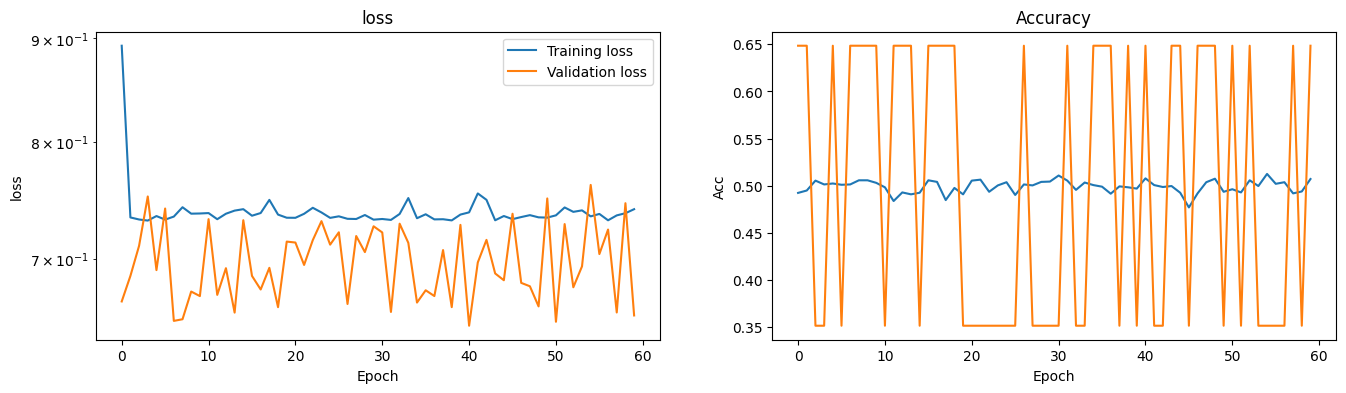

In [48]:
# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

## Again ... bad model. 
This has been a consistent issue of mine, even with decent models (i.e., models with good loss curves but bad learning curves). I am thinking that this is a data pre-processing issue. 